In [1]:
# dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from timing_diagram import time_diagram_plotter
from ShipDetectionSystemDesign import *
from spherical_earth_geometry_radar import *
from design_functions import *
from ambiguity_functions import *
from matplotlib import cm

matplotlib.use('Qt5Agg')
%matplotlib widget

# System design Assumptions
- small antenna area 0.3 m x 2 m
- Low Peak Power ~ 200 W i.e. 1/6 Synspective
- High Duty cycle (to compensate for the low peak power) ~ 25%
- Losses + Noise Figure = 10dB (conservative)
- Resolution Area < 2m^2 (like terraSar spotlight)
- Pfa <= 10^-6 i.e. less than 1 fa for NZ EEZ
- 30 m x 7 m vessels to be detected
- LEO = 500 km


In [2]:
# antenna
la = 2  # m
wa = .3  # m
# losses + Nf
losses = 10  # dB
# orbit
h = 500e3  # m
# resolution area
ares = 2  # m2
# duty cycle
dutycycle = 0.25
# power
P_peak = 200  # W
pavg = dutycycle * P_peak  # W
# frequency
freq = 10e9
# wavelength
wavel = 299792458.0 / freq
# speed of light
c = 299792458.0

print('P_avg: ', pavg)

P_avg:  50.0


In [3]:
# probability of detection and false alarm
# expected value and variance for MEDIUM ships (150m>L>25m) 
#(from Table 1 in DLR paper) better performance are expected 
# given the higher resolution
# related to the intensity log normal distribution of ships
expected = - 0.002
variance = 4.66

# for small ships with ares , 2m2
# expected = - 0.928
# variance = 3.796

# 30 m x 7 m vessels
A_ship = 30 * 7

#Pfa = 1 * A_ship / 10 ** 7
Pfa = 10e-6

# minimum probability of detection
pd_min = 0.45


# II Analysis
sweep over a set of looking angle

In [4]:
out_dict_list = []
in_dict_list = []
#theta_mean = np.array([15, 20, 25, 30, 35, 40, 45, 50, 55, 60])
theta_mean = np.arange(20, 61, 5)

for theta in tqdm(theta_mean):
    out_dict, in_dict = shipDetectionSystemDesigner(theta, la, wa, ares, h, freq, P_peak, dutycycle, losses, Pfa,
                                                    A_ship, expected, variance, pd_min)
    in_dict_list.append(in_dict)
    out_dict_list.append(out_dict)
# reduced swath design
for theta in tqdm(theta_mean):
    out_dict, in_dict = shipDetectionSystemDesigner(theta, la, wa, ares, h, freq, P_peak, dutycycle, losses, Pfa,
                                                    A_ship, expected, variance, pd_min,
                                                    reducedSwath=True, swathnominalfraction= 0.7)
    in_dict_list.append(in_dict)
    out_dict_list.append(out_dict)


100%|██████████| 9/9 [00:13<00:00,  1.50s/it]


# III Performance Evaluation - discussion
For every design, print/plot:
-	The Probability of detection over swath for different looking angles (plot)
-	NESZ min
-	The Range Ambiguity to signal Ratio over swath (plot or maximum value)
-	The Azimuth Ambiguity to Signal Ratio
-	The Required pulse bandwidth
-	The PRF
-	The swath width that effectively has a Pd higher than 0.5
-	Whether the swath is nominal or larger (3dB beam)
-	The timing Diagram (Plot)


## Plots

In [5]:
# for the plots: to be filled for every initial looking angle
# a list of broadside incidence angles for the legend
broadside_incidence_list = []
# a list of usable ground range axes
ground_range_axis_list = []
# a list of usable swath incidence angle axes
incidence_axis_list = []
# a list of probability of detection curves
pd_list = []
# a list of NESZ curves
nesz_list = []
# a list of RASR curves
rasr_list = []
# a list of AASR points
aasr_list = []
# undersampling ratios
undersampling_list = []
# a list of minimum probabilities of detection lines
pd_min_line_inc_list = []

In [6]:
# filling the lists
points = 111  # number of points per plot
for out_dict in tqdm(out_dict_list):
    # broadside incidence
    broadside_incidence = out_dict['broadside_incidence']
    broadside_incidence_list.append(broadside_incidence)

    # incidence axis
    iminmax = out_dict['usable_inc_swath']
    incidence = np.linspace(iminmax[0], iminmax[1], points)
    incidence_axis_list.append(incidence)

    # ground range axis ( from incidence )
    slant_range, ground_range = range_from_theta(incidence * 180 / np.pi, h)
    ground_range_axis_list.append(ground_range)

    # NESZ curve
    radGeo = out_dict['radarGeo']
    uniap = out_dict['uniAp']
    v_s = radGeo.abs_v
    snr_core, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h)
    B = out_dict['bandwidth']
    Ta = 300  # kelvin (antenna temperature)
    nesz = 10 ** (losses / 10) * Ta * B / (snr_core * pavg)
    nesz_list.append(nesz)

    # probability of detection curve
    P_d = pd(radGeo, uniap, incidence, wavel, losses, B, pavg, Pfa, A_ship, expected, variance)
    pd_list.append(P_d)

    # RASR curve
    #  Doppler Bandwidth
    Bd = nominal_doppler_bandwidth(uniap.L, broadside_incidence, wavel, v_s, h)
    PRI_2 = out_dict['PRI_2']
    rasr = RASR(radGeo, uniap, incidence, PRI_2, Bd, wavel, v_s, pbaroff=True)
    rasr_list.append(rasr)

    # undersampling ratio
    undersampling_list.append(Bd * PRI_2)

    # minimum probabilities of detection line
    pd_min_inc = out_dict['pd_inc_swath']
    pd_min_line_inc_list.append(pd_min_inc)

    # AASR points
    aasr = AASR(radGeo, uniap, np.average(iminmax) * 180 / np.pi, 1/PRI_2, Bd, wavel, pbaroff=True)
    aasr_list.append(aasr)


  0%|          | 0/18 [00:00<?, ?it/s]C:\Users\smen851\PycharmProjects\design-baseline\spherical_earth_geometry_radar.py:287: RuntimeWarning: invalid value encountered in sqrt
  arg = ((lambda_c ** 2 * doppler_mesh ** 2 + np.sqrt(
100%|██████████| 18/18 [03:28<00:00, 11.56s/it]


In [7]:
# plotting the stuff

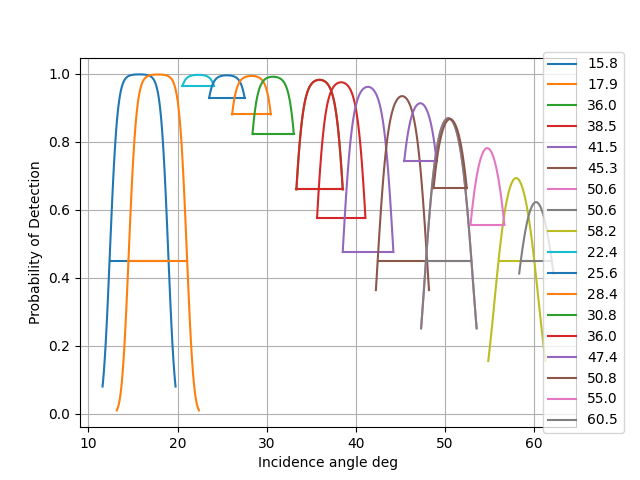

In [20]:
# pd plot
fig, ax = plt.subplots(1)
for ii in range(len(incidence_axis_list)):
    ax.plot(incidence_axis_list[ii] * 180 / np.pi, pd_list[ii], color=cm.get_cmap('tab10').colors[ii%10])
    # min pd line
    inc_pd_min = pd_min_line_inc_list[ii]
    ax.plot(inc_pd_min * 180 / np.pi, out_dict_list[ii]['pd_min'], 
            color=cm.get_cmap('tab10').colors[ii%10],
            label = str(round(broadside_incidence_list[ii][0]*180/np.pi,1)))

ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('Probability of Detection')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.11, 0.5))

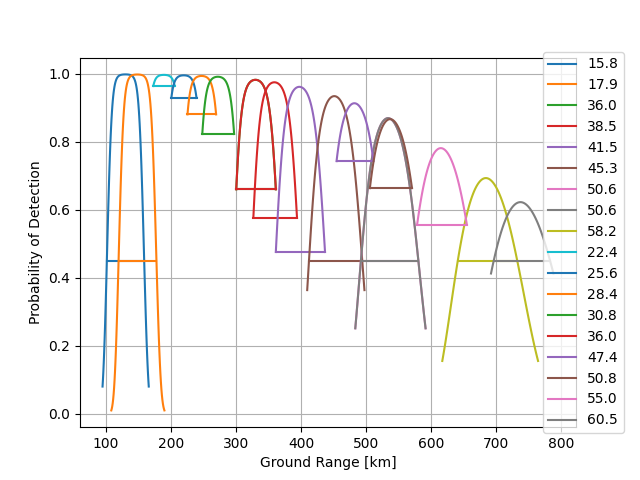

In [22]:
# pd plot on ground range
fig, ax = plt.subplots(1)
for ii in range(len(incidence_axis_list)):
    ax.plot(ground_range_axis_list[ii]/1000, pd_list[ii], color=cm.get_cmap('tab10').colors[ii%10])
    # min pd line
    inc_pd_min = pd_min_line_inc_list[ii]
    ax.plot(out_dict_list[ii]['pd_ground_swath'] / 1000, out_dict_list[ii]['pd_min'], 
            color=cm.get_cmap('tab10').colors[ii%10],
            label = str(round(broadside_incidence_list[ii][0]*180/np.pi,1)))

ax.set_xlabel('Ground Range [km]')
ax.set_ylabel('Probability of Detection')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.11, 0.5))

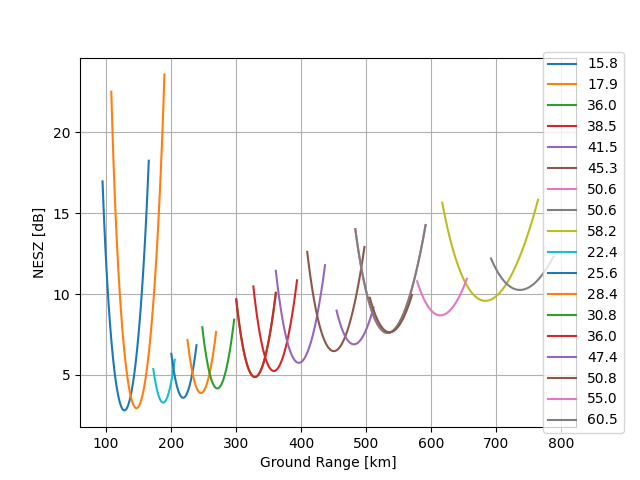

In [23]:
# nesz plot on ground range
fig, ax = plt.subplots(1)
for ii in range(len(incidence_axis_list)):
    ax.plot(ground_range_axis_list[ii]/1000, 10 * np.log10(nesz_list[ii]), 
            color=cm.get_cmap('tab10').colors[ii%10],
            label = str(round(broadside_incidence_list[ii][0]*180/np.pi,1)))


ax.set_xlabel('Ground Range [km]')
ax.set_ylabel('NESZ [dB]')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.11, 0.5))

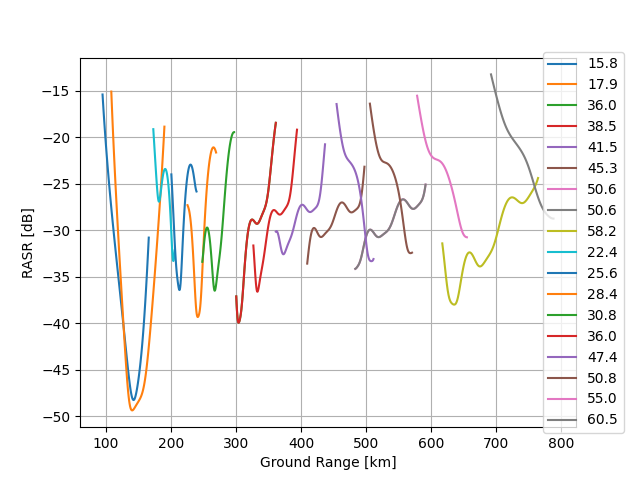

In [24]:
# RASR plot on ground range
fig, ax = plt.subplots(1)
for ii in range(len(incidence_axis_list)):
    ax.plot(ground_range_axis_list[ii]/1000, 10 * np.log10(rasr_list[ii]), 
            color=cm.get_cmap('tab10').colors[ii%10],
            label = str(round(broadside_incidence_list[ii][0]*180/np.pi,1)))


ax.set_xlabel('Ground Range [km]')
ax.set_ylabel('RASR [dB]')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.11, 0.5))

## Timing diagram

C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:42: RuntimeWarning: invalid value encountered in arccos
  beta = arccos(((re + h) ** 2 - re ** 2 + rs ** 2) / (2 * (re + h) * rs))
C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:43: RuntimeWarning: invalid value encountered in arccos
  alpha = arccos(((re + h) ** 2 + re ** 2 - rs ** 2) / (2 * (re + h) * re))


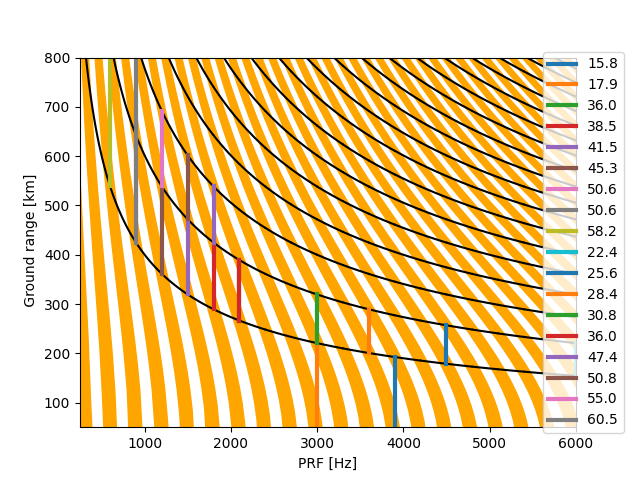

In [25]:
# timing diagram
prf = np.linspace(250, 6000, 200)
# plotting
fig, ax = plt.subplots(1)
time_diagram_plotter(ax, prf, dutycycle, h)
ax.set_xlabel('PRF [Hz]')
ax.set_ylabel(' Ground range [km]')
ax.set_ylim(50, 800 )
ax.set_xlim(250, 6000)

# design points
for ii in range(len(incidence_axis_list)):
    swath_g = out_dict_list[ii]['ground_swath']
    PRI_2 = out_dict_list[ii]['PRI_2']
    prff = np.abs(np.ones_like(swath_g) / PRI_2)
    ax.plot(prff, swath_g / 1000, 
            color=cm.get_cmap('tab10').colors[ii%10], linewidth=3,
            label = str(round(broadside_incidence_list[ii][0]*180/np.pi,1)))
ax.legend(loc='center right', bbox_to_anchor=(1.11, 0.5))

## Table
AASR

In [51]:
print('eta ','\t pd_min swath', '\t AASR', '\t\t bandwidth', '\t Bd/PRF')
for ii in range(len(out_dict_list)):
    dict = out_dict_list[ii]
    a = aasr_list[ii][0]
    uu = undersampling_list[ii][0]
    swath = dict['pd_ground_swath']
    angle = dict['broadside_incidence'] * 180 / np.pi
    print(round(angle[0], 2),'\t',
          round(( swath[1]-swath[0] )/1000, 2), 'km', '\t',round(a,2), 'dB',
          '\t',round(dict['bandwidth']/1e6,2),'MHz','\t', round(uu,2))

eta  	 pd_min swath 	 AASR 		 bandwidth 	 Bd/PRF
15.75 	 57.38 km 	 1.59 dB 	 277.37 MHz 	 1.95
17.85 	 58.21 km 	 2.31 dB 	 245.33 MHz 	 2.54
36.03 	 60.82 km 	 4.46 dB 	 127.73 MHz 	 3.63
38.47 	 67.08 km 	 4.22 dB 	 120.77 MHz 	 4.23
41.48 	 75.59 km 	 5.29 dB 	 113.41 MHz 	 5.08
45.35 	 81.86 km 	 6.74 dB 	 105.59 MHz 	 6.35
50.57 	 88.3 km 	 9.51 dB 	 97.23 MHz 	 8.47
50.57 	 88.3 km 	 9.51 dB 	 97.23 MHz 	 8.47
58.25 	 91.4 km 	 12.64 dB 	 88.32 MHz 	 12.7
22.38 	 32.91 km 	 1.15 dB 	 197.41 MHz 	 1.27
25.61 	 38.65 km 	 1.85 dB 	 173.9 MHz 	 1.69
28.37 	 43.93 km 	 2.5 dB 	 158.15 MHz 	 2.12
30.81 	 48.91 km 	 3.4 dB 	 146.72 MHz 	 2.54
36.03 	 60.82 km 	 4.46 dB 	 127.73 MHz 	 3.63
47.4 	 56.73 km 	 4.14 dB 	 102.09 MHz 	 4.23
50.75 	 64.7 km 	 4.95 dB 	 97.03 MHz 	 5.08
54.97 	 76.5 km 	 6.01 dB 	 91.77 MHz 	 6.35
60.51 	 86.59 km 	 7.87 dB 	 86.33 MHz 	 8.47
